In [35]:
"""Baseline model. 1 layer LSTM with a classification layer trained for 100 epochs"""

'Baseline model. 1 layer LSTM with a classification layer trained for 100 epochs'

In [229]:
import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from joblib import dump, load

from sklearn.model_selection import train_test_split

In [115]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)

In [116]:
df.head(5)

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci
0,2013-01-01,1.3205,1.3194,1.3220,1.3180,0.07%,NaN,NaN,NaN,1.320500,1.320500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1.3186,1.3205,1.3302,1.3157,-0.14%,-0.0019,0.0,NaN,1.318956,1.319550,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,2013-01-03,1.3048,1.3187,1.3192,1.3046,-1.05%,-0.0138,1.0,NaN,1.307931,1.314633,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
3,2013-01-04,1.3069,1.3048,1.3091,1.2999,0.16%,0.0021,2.0,NaN,1.307136,1.312700,NaN,NaN,NaN,NaN,13.559663,NaN,NaN,NaN
4,2013-01-07,1.3117,1.3072,1.3121,1.3018,0.37%,0.0048,2.0,NaN,1.310649,1.312500,NaN,NaN,NaN,NaN,36.329386,NaN,NaN,NaN


In [117]:
import tensorflow.keras

In [151]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

def prepare_data(df, n=3):
    """
    n: number of days to window together 
    """
    df["label_3days"] = df["label"].shift(-3)
    df["label_5days"] = df["label"].shift(-5)
    df = df.dropna(axis=0)
    df = df.reset_index(drop=True)

    time = ["Date"]
    var = ["Price",  "sma", "ema", "cma", "macd",	"macd_s", 
               "macd_h", "roc", "rsi",	"Bollinger_up", "Bollinger_down", "cci"]
    columns = []
    for v in var:
        columns.append(v)
        for i in range(n - 1, 0, -1):
            columns.append(v + f"(t-{i})")
    
    labels = ["label", "label_3days", "label_5days"]
    features = df[time + columns + labels]

    X = features.drop(labels= time + labels, axis=1)
    print(X.head(5))
    Y = features[["label"]]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    onehot_encoder = OneHotEncoder()
    Y = to_categorical(Y)
    
    return X, Y, features
    

In [152]:
from pandas import concat

def window(df, n=3):
    """
    Given time series data, window it such that we can get (t-n), (t-n-1) .. (t-1) and (t)
    """
    if n < 1:
        raise ValueError("n should be >= 1")
    n_var = df.shape[1]
    cols, names = list(), list()
    
    for i in range(n - 1, -1, -1):
        cols.append(df.shift(i))
        if i > 0:
            names += [(f"{j}(t-{i})") for j in list(df.columns)]
        else:
            names += [(f"{j}") for j in list(df.columns)]
    agg = concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

def prepare_and_window_data(df, n=3):
    df = window(df, n=n)
    return prepare_data(df, n=n)

def get_data_split(df, test_size=0.2, random_state=420, window_size=3):
    X, Y, features = prepare_and_window_data(df, n=window_size)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=420)
    return X_train, X_test, Y_train, Y_test


In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy

def build_model(X_dim, h_dim=100, num_classes=3):
    model = Sequential()
    model.add(LSTM(units=h_dim, input_shape=(X_dim, 1)))
    model.add(Dense(num_classes))
    model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [175]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = get_data_split(df, window_size=3)

    Price  Price(t-2)  Price(t-1)       sma  sma(t-2)  sma(t-1)       ema  \
0  1.3388      1.3363      1.3352  1.345260  1.344735  1.344925  1.338051   
1  1.3281      1.3352      1.3388  1.345075  1.344925  1.345260  1.330396   
2  1.3189      1.3388      1.3281  1.344140  1.345260  1.345075  1.321553   
3  1.3190      1.3281      1.3189  1.342780  1.345075  1.344140  1.319589   
4  1.3062      1.3189      1.3190  1.340810  1.344140  1.342780  1.309290   

   ema(t-2)  ema(t-1)       cma  ...   rsi(t-1)  Bollinger_up  \
0  1.336730  1.335553  1.335408  ...  38.588551      1.363601   
1  1.335553  1.338051  1.335211  ...  45.544851      1.364052   
2  1.338051  1.330396  1.334782  ...  32.802173      1.366251   
3  1.330396  1.321553  1.334377  ...  25.675429      1.367545   
4  1.321553  1.319589  1.333673  ...  25.877405      1.370424   

   Bollinger_up(t-2)  Bollinger_up(t-1)  Bollinger_down  Bollinger_down(t-2)  \
0           1.364281           1.363994        1.326919           

In [206]:
X_train_2.shape

(1843, 36)

In [177]:
model_2 = build_model(X_dim=X_train_2.shape[1])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 303       
Total params: 41,103
Trainable params: 41,103
Non-trainable params: 0
_________________________________________________________________


In [178]:
hist = model_2.fit(X_train_2, Y_train_2, validation_data=(X_test_2, Y_test_2), epochs=100, batch_size=64)

Epoch 1/100


ValueError: in user code:

    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_16 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 36)


In [154]:
from tqdm import tqdm
def run_experiment(df, start=1, end=10, epochs=100, batch_size=64):
    """
    Conduct an experiment to identify the optimal window size.
    start: Starting window size
    end: Ending window size
    Return: A dictionary containing validation accuracy for each window size
    """
    results = {}
    for cur_win_size in tqdm(range(start, end + 1)):
        X_train, X_test, Y_train, Y_test = get_data_split(df, window_size=cur_win_size)
        model = build_model(X_dim=X_train.shape[1])
        hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size)
        results[cur_win_size] = hist.history['accuracy'][-1]
    return results

In [155]:
results = run_experiment(df)
results

  0%|          | 0/10 [00:00<?, ?it/s]


    Price       sma       ema       cma      macd    macd_s    macd_h  \
0  1.3363  1.344735  1.336730  1.335315  0.002701  0.005461 -0.002760   
1  1.3352  1.344925  1.335553  1.335311  0.001906  0.004750 -0.002844   
2  1.3388  1.345260  1.338051  1.335408  0.001549  0.004109 -0.002561   
3  1.3281  1.345075  1.330396  1.335211  0.000398  0.003367 -0.002969   
4  1.3189  1.344140  1.321553  1.334782 -0.001242  0.002445 -0.003688   

        roc        rsi  Bollinger_up  Bollinger_down         cci  
0 -0.000150  39.939646      1.364281        1.325189  -62.849696  
1 -0.004102  38.588551      1.363994        1.325856  -68.561252  
2 -0.004906  45.544851      1.363601        1.326919  -57.039491  
3 -0.012785  32.802173      1.364052        1.326098  -90.131403  
4 -0.012873  25.675429      1.366251        1.322029 -149.263447  
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm

ValueError: in user code:

    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_12 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 12)


In [7]:
# Without price as a factor

# Attempt 2

In [216]:
def lstm_data_transform(x_data, y_data, num_steps=3):
    """ Changes data to the format for LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    # for i in range(x_data.shape[0]):

    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix - 1]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [250]:
df.head()

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label_3days,label_5days
0,2013-02-15,1.3363,1.3363,1.3394,1.3306,0.01%,0.0002,0.0,1.344735,1.336730,...,0.002701,0.005461,-0.002760,-0.000150,39.939646,1.364281,1.325189,-62.849696,1.0,0.0
1,2013-02-18,1.3352,1.3357,1.3377,1.3321,-0.08%,-0.0011,0.0,1.344925,1.335553,...,0.001906,0.004750,-0.002844,-0.004102,38.588551,1.363994,1.325856,-68.561252,1.0,1.0
2,2013-02-19,1.3388,1.3352,1.3397,1.3329,0.27%,0.0036,2.0,1.345260,1.338051,...,0.001549,0.004109,-0.002561,-0.004906,45.544851,1.363601,1.326919,-57.039491,0.0,0.0
3,2013-02-20,1.3281,1.3387,1.3434,1.3270,-0.80%,-0.0107,1.0,1.345075,1.330396,...,0.000398,0.003367,-0.002969,-0.012785,32.802173,1.364052,1.326098,-90.131403,1.0,2.0
4,2013-02-21,1.3189,1.3283,1.3291,1.3161,-0.69%,-0.0092,1.0,1.344140,1.321553,...,-0.001242,0.002445,-0.003688,-0.012873,25.675429,1.366251,1.322029,-149.263447,0.0,1.0


In [252]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Change %', 'diff_1', 'label',
       'sma', 'ema', 'cma', 'macd', 'macd_s', 'macd_h', 'roc', 'rsi',
       'Bollinger_up', 'Bollinger_down', 'cci', 'label_3days', 'label_5days'],
      dtype='object')

In [217]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"])

# Labels 3 days ahead
df["label_3days"] = df["label"].shift(-3)

# Labels 5 days ahead
df["label_5days"] = df["label"].shift(-5)
# Drop NA
df = df.dropna(axis = 0)
df = df.reset_index(drop=True)
df.head()
features = df.drop(labels =  ["Open", "High", "Low","Change %", "diff_1"], axis=1)
features.head()
X = features.drop(labels= ["Date"] + ["label", "label_3days", "label_5days"] + ["Price"], axis = 1)
X.head()

,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci
0,1.344735,1.336730,1.335315,0.002701,0.005461,-0.002760,-0.000150,39.939646,1.364281,1.325189,-62.849696
1,1.344925,1.335553,1.335311,0.001906,0.004750,-0.002844,-0.004102,38.588551,1.363994,1.325856,-68.561252
2,1.345260,1.338051,1.335408,0.001549,0.004109,-0.002561,-0.004906,45.544851,1.363601,1.326919,-57.039491
3,1.345075,1.330396,1.335211,0.000398,0.003367,-0.002969,-0.012785,32.802173,1.364052,1.326098,-90.131403
4,1.344140,1.321553,1.334782,-0.001242,0.002445,-0.003688,-0.012873,25.675429,1.366251,1.322029,-149.263447


In [218]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 1.84392654,  1.76562961,  1.70005358, ...,  1.8683638 ,
         1.80152324, -0.65041763],
       [ 1.84605032,  1.75246368,  1.69999683, ...,  1.8651378 ,
         1.80889088, -0.71655935],
       [ 1.8497949 ,  1.78040628,  1.70167462, ...,  1.86074147,
         1.82061006, -0.5831335 ],
       ...,
       [-0.56483883, -0.53162927, -0.96953338, ..., -0.69084061,
        -0.43521197,  0.62254833],
       [-0.55802035, -0.51948747, -0.96989049, ..., -0.69725765,
        -0.41543563,  0.97031967],
       [-0.55802035, -0.5261519 , -0.97025541, ..., -0.69725765,
        -0.41543563,  0.92950638]])

In [219]:
y = tf.keras.utils.to_categorical(features["label"])

In [220]:
print(X.shape)
print(y.shape)

(2311, 11)
(2311, 3)


In [221]:
X_ds, y_ds = lstm_data_transform(X, y, num_steps=5)

print(X_ds.shape)
print(y_ds.shape)

(2306, 5, 11)
(2306, 3)


In [222]:
# X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=0.2, random_state=420)
# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)


# Train Test Split
TEST_SPLIT = 0.8

X_train = X_ds[: int(len(X_ds) * TEST_SPLIT)]
X_test = X_ds[int(len(X_ds) * TEST_SPLIT) : ]

y_train = y_ds[:int(len(X_ds) * TEST_SPLIT)]
y_test = y_ds[int(len(X_ds) * TEST_SPLIT):]

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(1844, 5, 11)
(1844, 3)
(462, 5, 11)
(462, 3)


In [223]:
model = Sequential()

# model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units=100, input_shape=(X_train.shape[1], 11), return_sequences=True))
model.add(LSTM(units=100))
model.add(Dense(64, activation="relu"))
model.add(Dense(3))
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 5, 100)            44800     
_________________________________________________________________
lstm_28 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 195       
Total params: 131,859
Trainable params: 131,859
Non-trainable params: 0
_________________________________________________________________


In [224]:
callbacks = []

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=5,
                                            restore_best_weights=True))


In [225]:
epochs = 20

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32,
    callbacks= callbacks
)

Epoch 1/20
58/58 [==============================] - 3s 14ms/step - loss: 1.0982 - accuracy: 0.3371 - val_loss: 1.0999 - val_accuracy: 0.3420
Epoch 2/20
58/58 [==============================] - 0s 7ms/step - loss: 1.0756 - accuracy: 0.4169 - val_loss: 1.1062 - val_accuracy: 0.3398
Epoch 3/20
58/58 [==============================] - 0s 8ms/step - loss: 1.0726 - accuracy: 0.4195 - val_loss: 1.1058 - val_accuracy: 0.3485
Epoch 4/20
58/58 [==============================] - 0s 8ms/step - loss: 1.0568 - accuracy: 0.4318 - val_loss: 1.0754 - val_accuracy: 0.3983
Epoch 5/20
58/58 [==============================] - 0s 8ms/step - loss: 1.0052 - accuracy: 0.4835 - val_loss: 0.7676 - val_accuracy: 0.6320
Epoch 6/20
58/58 [==============================] - 0s 8ms/step - loss: 0.6790 - accuracy: 0.6954 - val_loss: 0.3895 - val_accuracy: 0.8355
Epoch 7/20
58/58 [==============================] - 0s 8ms/step - loss: 0.3356 - accuracy: 0.8718 - val_loss: 0.3649 - val_accuracy: 0.8355
Epoch 8/20
58/58 [=

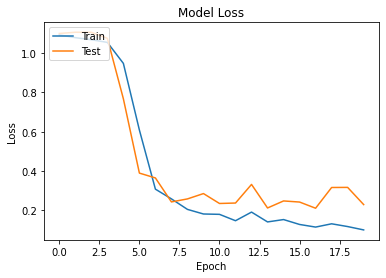

In [226]:
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

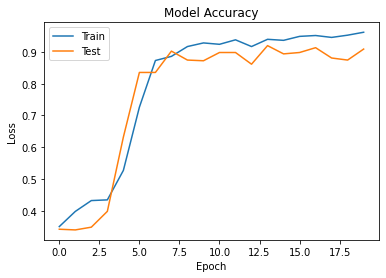

In [227]:
# Loss History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [228]:
model.evaluate(x=X_test, y=y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9091


[0.22936001420021057, 0.9090909361839294]

## Saving the Model

In [230]:
MODEL_PATH = "../../results/models/Signal_LSTM_v1"

model.save(MODEL_PATH)
dump(scaler, os.path.join(MODEL_PATH, "scaler.save"))

2022-03-29 22:14:31.943222: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../results/models/Signal_LSTM_v1/assets


INFO:tensorflow:Assets written to: ../../results/models/Signal_LSTM_v1/assets


['../../results/models/Signal_LSTM_v1/scaler.save']

##  Loading the Model

In [244]:
from sklearn.metrics import accuracy_score

In [231]:
PATH_TO_LOAD = "../../results/models/Signal_LSTM_v1"

In [ ]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"])
test_df = df.iloc[-462 - 5:]

In [234]:
loaded_scaler = load(os.path.join(PATH_TO_LOAD, "scaler.save"))
loaded_model = tf.keras.models.load_model(PATH_TO_LOAD)

In [237]:
pred = loaded_model.predict(X_test)

In [247]:
temp_actual = np.argmax(y_test, axis=1)
temp_pred = np.argmax(pred, axis=1)

In [248]:
accuracy_score(temp_actual, temp_pred)

0.9090909090909091

In [256]:
temp_x = features.drop(labels= ["Date"] + ["label", "label_3days", "label_5days"] + ["Price"], axis = 1)

In [258]:
temp_x.columns

Index(['sma', 'ema', 'cma', 'macd', 'macd_s', 'macd_h', 'roc', 'rsi',
       'Bollinger_up', 'Bollinger_down', 'cci'],
      dtype='object')

In [260]:
temp_x_transformed = loaded_scaler.transform(temp_x)

In [263]:
np.array_equal(temp_x_transformed, X)

True

In [265]:
df.tail()

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label_3days,label_5days
2306,2021-12-20,1.1275,1.1242,1.1305,1.1234,0.32%,0.0036,2.0,1.128420,1.127084,...,-0.003948,-0.004795,0.000847,-0.000709,46.839553,1.136446,1.120394,-27.330869,0.0,0.0
2307,2021-12-21,1.1283,1.1277,1.1303,1.1260,0.07%,0.0008,0.0,1.128605,1.128019,...,-0.003696,-0.004575,0.000879,0.002310,48.373952,1.136429,1.120781,-9.274996,0.0,0.0
2308,2021-12-22,1.1324,1.1279,1.1343,1.1264,0.36%,0.0041,2.0,1.129240,1.131389,...,-0.003130,-0.004286,0.001156,0.003456,55.900932,1.136011,1.122469,47.075103,0.0,2.0
2309,2021-12-23,1.1328,1.1325,1.1343,1.1289,0.04%,0.0004,0.0,1.129850,1.132474,...,-0.002618,-0.003952,0.001334,0.000000,56.613022,1.135439,1.124261,77.106303,0.0,1.0
2310,2021-12-24,1.1317,1.1330,1.1344,1.1303,-0.10%,-0.0011,0.0,1.129850,1.131879,...,-0.002276,-0.003617,0.001341,0.006940,53.853702,1.135439,1.124261,73.581941,2.0,2.0


# Testing Code

In [298]:
sys.path.append("../../src/")
# from Signal_LSTM import predict
import Signal_LSTM

In [299]:
PATH_TO_LOAD = "../../results/models/Signal_LSTM_v1"

In [300]:
sys.modules["Signal_LSTM"]

<module 'Signal_LSTM' from '../../src/Signal_LSTM.py'>

In [468]:
import importlib
importlib.reload(Signal_LSTM)

<module 'Signal_LSTM' from '../../src/Signal_LSTM.py'>

In [341]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"])

In [469]:
test_df = df.iloc[-462 - 5:]

In [473]:
result_df = Signal_LSTM.predict(test_df, path = PATH_TO_LOAD)
result_df

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,Pred
1882,2020-03-19,1.0690,1.0915,1.0982,1.0654,-2.04%,-0.0223,1.0,1.107490,1.074800,1.183894,-0.000745,0.003931,-0.004676,-0.044085,23.877925,1.145800,1.069180,-108.697395,NaN
1883,2020-03-20,1.0694,1.0691,1.0832,1.0637,0.04%,0.0004,0.0,1.106745,1.070646,1.183833,-0.003461,0.002452,-0.005913,-0.037010,24.319823,1.147458,1.066032,-120.426503,NaN
1884,2020-03-23,1.0721,1.0696,1.0828,1.0637,0.25%,0.0027,2.0,1.106090,1.071765,1.183774,-0.005334,0.000895,-0.006229,-0.041141,27.593536,1.148642,1.063538,-110.923061,NaN
1885,2020-03-24,1.0787,1.0726,1.0889,1.0722,0.62%,0.0066,2.0,1.105630,1.077100,1.183718,-0.006214,-0.000527,-0.005687,-0.019007,35.467042,1.149197,1.062063,-84.900046,NaN
1886,2020-03-25,1.0880,1.0789,1.0895,1.0761,0.86%,0.0093,2.0,1.105635,1.085485,1.183667,-0.006091,-0.001640,-0.004451,-0.003024,45.162255,1.149193,1.062077,-68.873073,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,2021-12-27,1.1325,1.1318,1.1335,1.1302,0.07%,0.0008,0.0,1.130020,1.132357,1.181063,-0.001917,-0.003277,0.001360,0.004435,55.666956,1.135719,1.124321,64.885520,0.0
2345,2021-12-28,1.1309,1.1329,1.1335,1.1289,-0.14%,-0.0016,0.0,1.129885,1.131236,1.181042,-0.001742,-0.002970,0.001228,0.002304,51.038878,1.135350,1.124420,35.968157,0.0
2346,2021-12-29,1.1348,1.1310,1.1370,1.1273,0.34%,0.0039,2.0,1.130030,1.133978,1.181022,-0.001275,-0.002631,0.001357,0.002119,60.317695,1.135861,1.124199,96.397770,2.0
2347,2021-12-30,1.1323,1.1349,1.1360,1.1298,-0.22%,-0.0025,1.0,1.130150,1.132687,1.181001,-0.001093,-0.002323,0.001231,-0.000441,52.902228,1.136068,1.124232,81.244514,1.0


In [474]:
temp = result_df[["Pred", "label"]].dropna()
pred_in_result_df = temp["Pred"]
actual_labels = temp["label"]

In [475]:
accuracy_score(actual_labels, pred_in_result_df)

0.9114470842332614